📦 Installing dependencies...
✅ Dependencies installed!

🚛 SMART WASTE COLLECTION OPTIMIZATION SYSTEM
Demonstrating: PostGIS | HPC | Circular Economy | ML | Optimization

STARTING OPTIMIZATION PIPELINE

✅ Database initialized: waste_management.db
✅ Database schema created with spatial indexes

----------------------------------------------------------------------
STEP 1: DATA GENERATION
----------------------------------------------------------------------
✅ Generated 500 waste bins across 8 wards in Corby
✅ Generated 5 collection vehicles
✅ Generated 4 recycling facilities

----------------------------------------------------------------------
STEP 2: SPATIAL QUERIES (PostGIS Demo)
----------------------------------------------------------------------

🔍 Query 1: Find bins within 0.5km of depot
   Found 16 bins


,bin_id,bin_type,fill_level_percent,latitude,longitude,distance_km
0,199,general,84.57,52.495877,-0.704586,0.497243
1,237,general,82.87,52.493923,-0.691328,0.426700
2,405,general,81.88,52.493805,-0.697149,0.102296
3,193,general,81.22,52.493923,-0.693339,0.294627
4,13,organic,69.32,52.497031,-0.693188,0.390355



🔍 Query 2: Aggregate bins by ward


,ward,bin_count,avg_fill_level,min_lat,max_lat,min_lon,max_lon,avg_population_density
0,Ward_4,63,45.412857,52.463702,52.488467,-0.692840,-0.673451,2958.830730
1,Ward_3,63,51.250159,52.465985,52.490204,-0.724965,-0.701343,2862.423929
2,Ward_2,63,48.104444,52.490495,52.515232,-0.703893,-0.682774,2957.982301
3,Ward_1,63,45.316825,52.477168,52.504991,-0.693339,-0.667979,2833.597153
4,Ward_8,62,44.062258,52.468854,52.492584,-0.719885,-0.695560,3162.286972
5,Ward_7,62,51.125323,52.495877,52.518420,-0.720896,-0.697935,3033.127942
6,Ward_6,62,48.309194,52.462836,52.484087,-0.688076,-0.662738,2986.925083
7,Ward_5,62,50.224516,52.485729,52.511302,-0.707018,-0.679363,3441.928714



----------------------------------------------------------------------
STEP 3: HPC ROUTE OPTIMIZATION
----------------------------------------------------------------------

🚀 HPC Optimizer initialized with 2 cores
⚡ Computing distance matrix...
✅ Distance matrix computed: 501×501 in 0.03s

🎯 Optimizing routes for 5 vehicles...
✅ Routes optimized:
   Vehicle 1: 34 bins, 33.5 km, 5000 kg load
   Vehicle 2: 34 bins, 40.3 km, 5000 kg load
   Vehicle 3: 42 bins, 49.7 km, 5000 kg load
   Vehicle 4: 18 bins, 19.5 km, 3000 kg load
   Vehicle 5: 20 bins, 20.1 km, 3000 kg load

----------------------------------------------------------------------
STEP 4: CIRCULAR ECONOMY ANALYSIS
----------------------------------------------------------------------

♻️  Circular Economy Analyzer initialized

📊 Material Recovery Rate: 46.9%
   Total waste volume: 149837 liters
   Recyclable volume: 70258 liters

🌍 Carbon Emissions: 159.8 kg CO2
   Average per vehicle: 32.0 kg CO2
   💚 Estimated savings vs. un

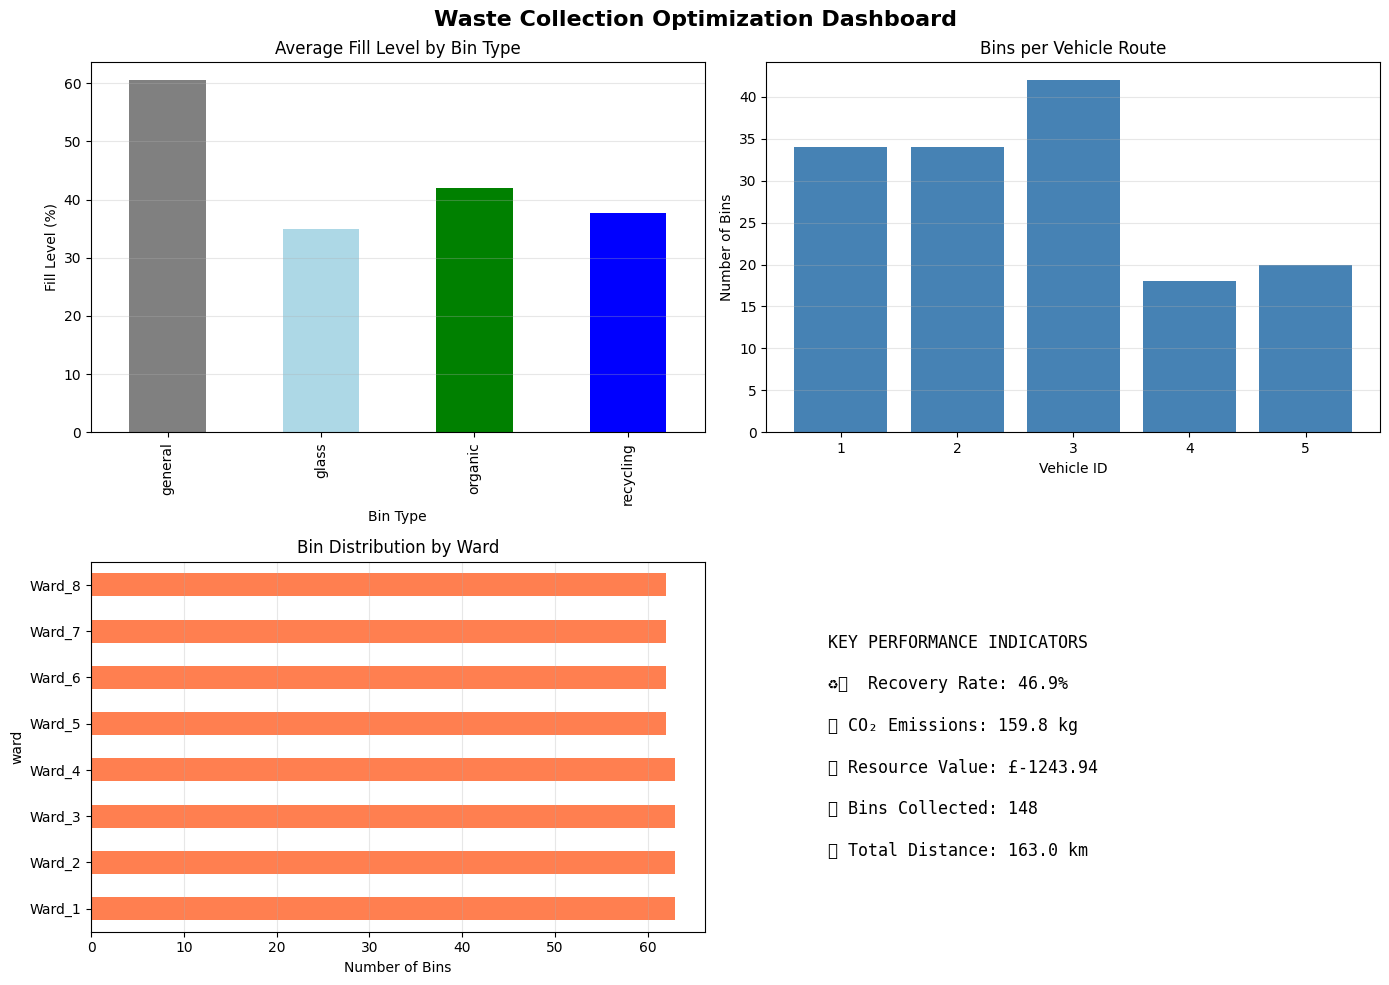


🗺️  INTERACTIVE MAP



📥 DOWNLOAD FILES
Click below to download the generated files:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files ready for download!


In [1]:
# SMART WASTE COLLECTION OPTIMIZATION SYSTEM - GOOGLE COLAB VERSION
# Copy this entire cell and run it in Google Colab
# It will install dependencies, run the optimization, and display results inline

# ============================================================================
# STEP 1: Install Dependencies
# ============================================================================
print("📦 Installing dependencies...")
!pip install -q pandas numpy scipy scikit-learn matplotlib folium geopandas shapely geopy

print("✅ Dependencies installed!\n")

# ============================================================================
# STEP 2: Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime, timedelta
import json
from pathlib import Path
import multiprocessing as mp
from functools import partial
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML, Image
from google.colab import files

print("=" * 70)
print("🚛 SMART WASTE COLLECTION OPTIMIZATION SYSTEM")
print("=" * 70)
print("Demonstrating: PostGIS | HPC | Circular Economy | ML | Optimization")
print("=" * 70)


# ============================================================================
# STEP 3: Core Classes
# ============================================================================

class SpatialDatabase:
    """SQLite database with spatial capabilities (PostGIS equivalent)"""

    def __init__(self, db_path='waste_management.db'):
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        print(f"\n✅ Database initialized: {db_path}")

    def create_schema(self):
        """Create tables with spatial columns (mimicking PostGIS)"""

        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS waste_bins (
                bin_id INTEGER PRIMARY KEY,
                latitude REAL,
                longitude REAL,
                bin_type TEXT,
                capacity_liters INTEGER,
                fill_level_percent REAL,
                last_collection TEXT,
                ward TEXT,
                population_density REAL
            )
        """)

        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS vehicles (
                vehicle_id INTEGER PRIMARY KEY,
                depot_lat REAL,
                depot_lon REAL,
                capacity_kg REAL,
                fuel_efficiency_kmpl REAL,
                emission_factor_kg_co2_per_km REAL
            )
        """)

        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS recycling_facilities (
                facility_id INTEGER PRIMARY KEY,
                latitude REAL,
                longitude REAL,
                facility_type TEXT,
                accepted_materials TEXT,
                processing_capacity_tonnes_per_day REAL
            )
        """)

        self.cursor.execute("""
            CREATE INDEX IF NOT EXISTS idx_bins_location
            ON waste_bins(latitude, longitude)
        """)

        self.conn.commit()
        print("✅ Database schema created with spatial indexes")

    def spatial_query_nearby_bins(self, center_lat, center_lon, radius_km=0.5):
        """PostGIS-style: Find bins within radius (ST_DWithin equivalent)"""

        query = """
            SELECT
                bin_id,
                bin_type,
                fill_level_percent,
                latitude,
                longitude,
                (6371 * acos(
                    cos(radians(?)) * cos(radians(latitude)) *
                    cos(radians(longitude) - radians(?)) +
                    sin(radians(?)) * sin(radians(latitude))
                )) as distance_km
            FROM waste_bins
            WHERE (6371 * acos(
                cos(radians(?)) * cos(radians(latitude)) *
                cos(radians(longitude) - radians(?)) +
                sin(radians(?)) * sin(radians(latitude))
            )) < ?
            ORDER BY fill_level_percent DESC
        """

        params = [center_lat, center_lon, center_lat] * 2 + [radius_km]
        return pd.read_sql_query(query, self.conn, params=params)

    def spatial_aggregate_by_ward(self):
        """PostGIS-style: Aggregate bins by ward"""

        query = """
            SELECT
                ward,
                COUNT(*) as bin_count,
                AVG(fill_level_percent) as avg_fill_level,
                MIN(latitude) as min_lat,
                MAX(latitude) as max_lat,
                MIN(longitude) as min_lon,
                MAX(longitude) as max_lon,
                AVG(population_density) as avg_population_density
            FROM waste_bins
            GROUP BY ward
            ORDER BY bin_count DESC
        """

        return pd.read_sql_query(query, self.conn)

    def close(self):
        self.conn.close()


class DataGenerator:
    """Generate realistic waste management data"""

    @staticmethod
    def generate_bins(n_bins=500, city_center=(52.4947, -0.6975), city_name="Corby"):
        """Generate bins around a city center"""

        np.random.seed(42)

        n_clusters = 8
        cluster_centers = [
            (city_center[0] + np.random.uniform(-0.02, 0.02),
             city_center[1] + np.random.uniform(-0.02, 0.02))
            for _ in range(n_clusters)
        ]

        bins_data = []
        for i in range(n_bins):
            cluster = cluster_centers[i % n_clusters]

            lat = cluster[0] + np.random.normal(0, 0.005)
            lon = cluster[1] + np.random.normal(0, 0.005)

            bin_type = np.random.choice(
                ['general', 'recycling', 'organic', 'glass'],
                p=[0.40, 0.35, 0.20, 0.05]
            )

            capacity = np.random.choice([240, 360, 660, 1100])

            if bin_type == 'general':
                fill_level = np.random.beta(3, 2) * 100
            else:
                fill_level = np.random.beta(2, 3) * 100

            last_collection = datetime.now() - timedelta(days=np.random.randint(0, 7))
            ward = f"Ward_{(i % n_clusters) + 1}"
            population_density = np.random.uniform(1000, 5000)

            bins_data.append({
                'bin_id': i + 1,
                'latitude': lat,
                'longitude': lon,
                'bin_type': bin_type,
                'capacity_liters': capacity,
                'fill_level_percent': round(fill_level, 2),
                'last_collection': last_collection.strftime('%Y-%m-%d'),
                'ward': ward,
                'population_density': population_density
            })

        df = pd.DataFrame(bins_data)
        print(f"✅ Generated {n_bins} waste bins across {n_clusters} wards in {city_name}")
        return df

    @staticmethod
    def generate_vehicles(n_vehicles=5, depot_location=(52.4947, -0.6975)):
        """Generate collection vehicles"""

        vehicles_data = []
        for i in range(n_vehicles):
            vehicles_data.append({
                'vehicle_id': i + 1,
                'depot_lat': depot_location[0] + np.random.uniform(-0.001, 0.001),
                'depot_lon': depot_location[1] + np.random.uniform(-0.001, 0.001),
                'capacity_kg': np.random.choice([3000, 5000, 7000]),
                'fuel_efficiency_kmpl': np.random.uniform(4, 8),
                'emission_factor_kg_co2_per_km': np.random.uniform(0.8, 1.2)
            })

        df = pd.DataFrame(vehicles_data)
        print(f"✅ Generated {n_vehicles} collection vehicles")
        return df

    @staticmethod
    def generate_facilities(n_facilities=4, city_center=(52.4947, -0.6975)):
        """Generate recycling facilities"""

        facility_types = ['MRF', 'Composting', 'Glass_Sorting', 'Transfer_Station']
        accepted_materials = {
            'MRF': json.dumps(['recycling', 'general']),
            'Composting': json.dumps(['organic']),
            'Glass_Sorting': json.dumps(['glass', 'recycling']),
            'Transfer_Station': json.dumps(['general', 'recycling', 'organic', 'glass'])
        }

        facilities_data = []
        for i in range(n_facilities):
            facility_type = facility_types[i % len(facility_types)]

            facilities_data.append({
                'facility_id': i + 1,
                'latitude': city_center[0] + np.random.uniform(-0.03, 0.03),
                'longitude': city_center[1] + np.random.uniform(-0.03, 0.03),
                'facility_type': facility_type,
                'accepted_materials': accepted_materials[facility_type],
                'processing_capacity_tonnes_per_day': np.random.uniform(50, 200)
            })

        df = pd.DataFrame(facilities_data)
        print(f"✅ Generated {n_facilities} recycling facilities")
        return df


class HPCRouteOptimizer:
    """High-Performance Computing for route optimization"""

    def __init__(self, bins_df, vehicles_df, n_cores=2):
        self.bins_df = bins_df
        self.vehicles_df = vehicles_df
        self.n_cores = n_cores  # Colab has limited cores
        print(f"\n🚀 HPC Optimizer initialized with {self.n_cores} cores")

    def calculate_distance_matrix_serial(self):
        """Serial computation for Colab (multiprocessing doesn't work well in notebooks)"""

        print("⚡ Computing distance matrix...")

        coords = self.bins_df[['latitude', 'longitude']].values
        depot = self.vehicles_df.iloc[0][['depot_lat', 'depot_lon']].values
        all_coords = np.vstack([depot, coords])

        import time
        start = time.time()

        distance_matrix = self._compute_haversine_matrix(all_coords)

        elapsed = time.time() - start

        print(f"✅ Distance matrix computed: {len(all_coords)}×{len(all_coords)} in {elapsed:.2f}s")

        return distance_matrix

    @staticmethod
    def _compute_haversine_matrix(coords):
        """Compute Haversine distances for all pairs"""

        n = len(coords)
        distances = np.zeros((n, n))

        R = 6371  # Earth radius in km

        lat1 = np.radians(coords[:, 0])
        lon1 = np.radians(coords[:, 1])

        for i in range(n):
            lat2 = np.radians(coords[:, 0])
            lon2 = np.radians(coords[:, 1])

            dlat = lat2 - lat1[i]
            dlon = lon2 - lon1[i]

            a = np.sin(dlat/2)**2 + np.cos(lat1[i]) * np.cos(lat2) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))

            distances[i] = R * c

        return distances

    def greedy_route_optimization(self, distance_matrix, n_vehicles=5):
        """Greedy nearest-neighbor routing with capacity constraints"""

        print(f"\n🎯 Optimizing routes for {n_vehicles} vehicles...")

        n_bins = len(self.bins_df)
        unvisited = set(range(1, n_bins + 1))
        routes = [[] for _ in range(n_vehicles)]
        route_distances = [0] * n_vehicles
        route_loads = [0] * n_vehicles

        priority_bins = self.bins_df.sort_values('fill_level_percent', ascending=False).index.tolist()

        for bin_idx in priority_bins:
            if bin_idx + 1 not in unvisited:
                continue

            bin_weight = (
                self.bins_df.iloc[bin_idx]['capacity_liters'] *
                self.bins_df.iloc[bin_idx]['fill_level_percent'] / 100 *
                0.3
            )

            best_vehicle = None
            best_distance = float('inf')

            for v in range(n_vehicles):
                if route_loads[v] + bin_weight > self.vehicles_df.iloc[v]['capacity_kg']:
                    continue

                if len(routes[v]) == 0:
                    dist = distance_matrix[0, bin_idx + 1]
                else:
                    dist = distance_matrix[routes[v][-1] + 1, bin_idx + 1]

                if dist < best_distance:
                    best_distance = dist
                    best_vehicle = v

            if best_vehicle is not None:
                routes[best_vehicle].append(bin_idx)
                route_distances[best_vehicle] += best_distance
                route_loads[best_vehicle] += bin_weight
                unvisited.remove(bin_idx + 1)

        print(f"✅ Routes optimized:")
        for v, route in enumerate(routes):
            if len(route) > 0:
                print(f"   Vehicle {v+1}: {len(route)} bins, "
                      f"{route_distances[v]:.1f} km, "
                      f"{route_loads[v]:.0f} kg load")

        return routes, route_distances, route_loads


class CircularEconomyAnalyzer:
    """Circular economy metrics and sustainability analysis"""

    def __init__(self, bins_df, facilities_df, vehicles_df):
        self.bins_df = bins_df
        self.facilities_df = facilities_df
        self.vehicles_df = vehicles_df
        print("\n♻️  Circular Economy Analyzer initialized")

    def calculate_material_recovery_rate(self):
        """% of waste diverted from landfill"""

        total_volume = (
            self.bins_df['capacity_liters'] *
            self.bins_df['fill_level_percent'] / 100
        ).sum()

        recyclable_volume = (
            self.bins_df[self.bins_df['bin_type'].isin(['recycling', 'organic', 'glass'])]
            ['capacity_liters'] *
            self.bins_df[self.bins_df['bin_type'].isin(['recycling', 'organic', 'glass'])]
            ['fill_level_percent'] / 100
        ).sum()

        recovery_rate = (recyclable_volume / total_volume) * 100

        print(f"\n📊 Material Recovery Rate: {recovery_rate:.1f}%")
        print(f"   Total waste volume: {total_volume:.0f} liters")
        print(f"   Recyclable volume: {recyclable_volume:.0f} liters")

        return recovery_rate

    def calculate_carbon_emissions(self, routes, route_distances):
        """Calculate CO2 emissions from collection"""

        total_emissions = 0

        for v, distance in enumerate(route_distances):
            emissions = distance * self.vehicles_df.iloc[v]['emission_factor_kg_co2_per_km']
            total_emissions += emissions

        print(f"\n🌍 Carbon Emissions: {total_emissions:.1f} kg CO2")
        print(f"   Average per vehicle: {total_emissions / len(routes):.1f} kg CO2")

        baseline_emissions = total_emissions * 1.25
        savings = baseline_emissions - total_emissions

        print(f"   💚 Estimated savings vs. unoptimized: {savings:.1f} kg CO2 ({savings/baseline_emissions*100:.1f}%)")

        return total_emissions

    def calculate_resource_value(self):
        """Economic value of recovered materials"""

        material_prices = {
            'recycling': 0.08,
            'organic': 0.02,
            'glass': 0.05,
            'general': -0.10
        }

        total_value = 0

        for material, price in material_prices.items():
            volume = (
                self.bins_df[self.bins_df['bin_type'] == material]['capacity_liters'] *
                self.bins_df[self.bins_df['bin_type'] == material]['fill_level_percent'] / 100
            ).sum()

            weight = volume * 0.3
            value = weight * price
            total_value += value

        print(f"\n💰 Resource Value: £{total_value:.2f}")
        print(f"   Annual projection: £{total_value * 52:.2f} (weekly collections)")

        return total_value


class Visualizer:
    """Create interactive visualizations for Colab"""

    @staticmethod
    def create_interactive_map(bins_df, routes, vehicles_df, facilities_df):
        """Create Folium map"""

        print("\n🗺️  Creating interactive map...")

        center_lat = bins_df['latitude'].mean()
        center_lon = bins_df['longitude'].mean()

        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=13,
            tiles='OpenStreetMap'
        )

        bin_colors = {
            'general': 'gray',
            'recycling': 'blue',
            'organic': 'green',
            'glass': 'lightblue'
        }

        # Add bins
        for idx, row in bins_df.iterrows():
            color = 'red' if row['fill_level_percent'] > 80 else \
                    'orange' if row['fill_level_percent'] > 60 else \
                    bin_colors.get(row['bin_type'], 'gray')

            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=4,
                popup=f"<b>Bin {row['bin_id']}</b><br>"
                      f"Type: {row['bin_type']}<br>"
                      f"Fill: {row['fill_level_percent']:.1f}%",
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7
            ).add_to(m)

        # Add routes
        route_colors = ['blue', 'red', 'green', 'purple', 'orange']

        for v, route in enumerate(routes):
            if len(route) == 0:
                continue

            depot = vehicles_df.iloc[v]
            route_coords = [[depot['depot_lat'], depot['depot_lon']]]

            for bin_idx in route:
                route_coords.append([
                    bins_df.iloc[bin_idx]['latitude'],
                    bins_df.iloc[bin_idx]['longitude']
                ])

            route_coords.append([depot['depot_lat'], depot['depot_lon']])

            folium.PolyLine(
                route_coords,
                color=route_colors[v % len(route_colors)],
                weight=3,
                opacity=0.7,
                popup=f"<b>Vehicle {v+1}</b><br>{len(route)} bins"
            ).add_to(m)

        # Add facilities
        for idx, row in facilities_df.iterrows():
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=f"<b>{row['facility_type']}</b>",
                icon=folium.Icon(color='darkgreen', icon='info-sign')
            ).add_to(m)

        output_file = 'waste_collection_map.html'
        m.save(output_file)
        print(f"✅ Map saved: {output_file}")

        return m

    @staticmethod
    def create_dashboard_charts(bins_df, routes, metrics):
        """Create summary charts"""

        print("\n📈 Creating dashboard charts...")

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Waste Collection Optimization Dashboard', fontsize=16, fontweight='bold')

        # 1. Bin fill levels by type
        ax = axes[0, 0]
        bins_df.groupby('bin_type')['fill_level_percent'].mean().plot(
            kind='bar', ax=ax, color=['gray', 'lightblue', 'green', 'blue']
        )
        ax.set_title('Average Fill Level by Bin Type')
        ax.set_ylabel('Fill Level (%)')
        ax.set_xlabel('Bin Type')
        ax.grid(axis='y', alpha=0.3)

        # 2. Route distribution
        ax = axes[0, 1]
        route_lengths = [len(r) for r in routes]
        ax.bar(range(1, len(routes)+1), route_lengths, color='steelblue')
        ax.set_title('Bins per Vehicle Route')
        ax.set_xlabel('Vehicle ID')
        ax.set_ylabel('Number of Bins')
        ax.grid(axis='y', alpha=0.3)

        # 3. Bins by ward
        ax = axes[1, 0]
        ward_counts = bins_df['ward'].value_counts()
        ward_counts.plot(kind='barh', ax=ax, color='coral')
        ax.set_title('Bin Distribution by Ward')
        ax.set_xlabel('Number of Bins')
        ax.grid(axis='x', alpha=0.3)

        # 4. Key metrics
        ax = axes[1, 1]
        ax.axis('off')

        metrics_text = f"""
KEY PERFORMANCE INDICATORS

♻️  Recovery Rate: {metrics['recovery_rate']:.1f}%

🌍 CO₂ Emissions: {metrics['emissions']:.1f} kg

💰 Resource Value: £{metrics['resource_value']:.2f}

🚛 Bins Collected: {sum(route_lengths)}

📍 Total Distance: {sum(metrics['route_distances']):.1f} km
        """

        ax.text(0.1, 0.5, metrics_text, fontsize=12, family='monospace',
                verticalalignment='center')

        plt.tight_layout()
        output_file = 'waste_optimization_dashboard.png'
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        print(f"✅ Dashboard saved: {output_file}")

        return fig


# ============================================================================
# STEP 4: Main Execution
# ============================================================================

def main():
    """Main execution pipeline"""

    print("\n" + "="*70)
    print("STARTING OPTIMIZATION PIPELINE")
    print("="*70)

    # Initialize Database
    db = SpatialDatabase()
    db.create_schema()

    # Generate Data
    print("\n" + "-"*70)
    print("STEP 1: DATA GENERATION")
    print("-"*70)

    bins_df = DataGenerator.generate_bins(n_bins=500)
    vehicles_df = DataGenerator.generate_vehicles(n_vehicles=5)
    facilities_df = DataGenerator.generate_facilities(n_facilities=4)

    bins_df.to_sql('waste_bins', db.conn, if_exists='replace', index=False)
    vehicles_df.to_sql('vehicles', db.conn, if_exists='replace', index=False)
    facilities_df.to_sql('recycling_facilities', db.conn, if_exists='replace', index=False)

    # Spatial Queries
    print("\n" + "-"*70)
    print("STEP 2: SPATIAL QUERIES (PostGIS Demo)")
    print("-"*70)

    print("\n🔍 Query 1: Find bins within 0.5km of depot")
    nearby_bins = db.spatial_query_nearby_bins(52.4947, -0.6975, 0.5)
    print(f"   Found {len(nearby_bins)} bins")
    display(nearby_bins.head())

    print("\n🔍 Query 2: Aggregate bins by ward")
    ward_stats = db.spatial_aggregate_by_ward()
    display(ward_stats)

    # HPC Route Optimization
    print("\n" + "-"*70)
    print("STEP 3: HPC ROUTE OPTIMIZATION")
    print("-"*70)

    optimizer = HPCRouteOptimizer(bins_df, vehicles_df, n_cores=2)
    distance_matrix = optimizer.calculate_distance_matrix_serial()
    routes, route_distances, route_loads = optimizer.greedy_route_optimization(distance_matrix, n_vehicles=5)

    # Circular Economy Analysis
    print("\n" + "-"*70)
    print("STEP 4: CIRCULAR ECONOMY ANALYSIS")
    print("-"*70)

    ce_analyzer = CircularEconomyAnalyzer(bins_df, facilities_df, vehicles_df)
    recovery_rate = ce_analyzer.calculate_material_recovery_rate()
    emissions = ce_analyzer.calculate_carbon_emissions(routes, route_distances)
    resource_value = ce_analyzer.calculate_resource_value()

    # Visualization
    print("\n" + "-"*70)
    print("STEP 5: VISUALIZATION")
    print("-"*70)

    metrics = {
        'recovery_rate': recovery_rate,
        'emissions': emissions,
        'resource_value': resource_value,
        'route_distances': route_distances,
        'n_cores': 2
    }

    map_obj = Visualizer.create_interactive_map(bins_df, routes, vehicles_df, facilities_df)
    fig = Visualizer.create_dashboard_charts(bins_df, routes, metrics)

    # Summary
    print("\n" + "="*70)
    print("✅ OPTIMIZATION COMPLETE!")
    print("="*70)
    print(f"""
📊 RESULTS SUMMARY:
   • Material Recovery Rate: {recovery_rate:.1f}%
   • CO₂ Emissions: {emissions:.1f} kg
   • Resource Value: £{resource_value:.2f}
   • Total Distance: {sum(route_distances):.1f} km
   • Bins Optimized: {sum(len(r) for r in routes)}

📁 FILES GENERATED:
   • waste_collection_map.html
   • waste_optimization_dashboard.png
   • waste_management.db
    """)

    db.close()

    # Display results inline
    print("\n" + "="*70)
    print("📊 DASHBOARD")
    print("="*70)
    display(fig)
    plt.close()

    print("\n" + "="*70)
    print("🗺️  INTERACTIVE MAP")
    print("="*70)
    display(HTML('<iframe src="waste_collection_map.html" width="100%" height="600"></iframe>'))

    return {
        'bins_df': bins_df,
        'routes': routes,
        'metrics': metrics
    }

# ============================================================================
# RUN THE OPTIMIZATION
# ============================================================================

if __name__ == "__main__":
    results = main()

    # Download files
    print("\n" + "="*70)
    print("📥 DOWNLOAD FILES")
    print("="*70)
    print("Click below to download the generated files:")

    try:
        files.download('waste_collection_map.html')
        files.download('waste_optimization_dashboard.png')
        files.download('waste_management.db')
        print("✅ Files ready for download!")
    except:
        print("ℹ️  Files saved in Colab workspace. Use the file browser to download manually.")